# 1.0. Problem Definition

The National Diabetes Statistics Report identified that about 1 in 10 Americans have diabetes, and 1 in 3 have prediabetes. Diabetes occurs when the body does not make or utilize enough insulin for the body to be able to digest sugar into energy. People with Type 1 diabetes require taking insulin shots every day, but people with Type 2 and prediabetes may be able to prevent Type 1 diabetes with a change of lifestyle or better diet habits. Early detection is critical for those with Type 2 and prediabetes in order to curb the risk of Type 1 diabetes. This notebook aims to create a model that takes in various information about participants in the NHANES survey to determine if they have or at risk of having diabetes. 

In this specific notebook, we utilize a multitude of different algorithms on our dataset and graph the performance of each one.

# 2.0. Data Gathering and Import

In [1]:
# Import all packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


## 2.1. Gathering and Importing Data

In [2]:
import os
import tarfile
import urllib

# Declare default variables (2017-2018 data)
DOWNLOAD_ROOT = "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/"
LOCAL_DATA_PATH = os.path.join("datasets", "nhanes") + "/"
FILE_NAME = "P_DEMO.XPT"

# Function for easily retrieving NHANES data
def fetch_nhanes_data(file_name=FILE_NAME, nhanes_url=DOWNLOAD_ROOT,  nhanes_path=LOCAL_DATA_PATH):
    os.makedirs(nhanes_path, exist_ok=True)
    xpt_path = os.path.join(nhanes_path, file_name)
    url = nhanes_url + file_name
    urllib.request.urlretrieve(url, xpt_path)

In [3]:
# Retrieve 2013-2014 data
# Demographics Data (DEMO)
fetch_nhanes_data("DEMO_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH)
# 
fetch_nhanes_data("BMX_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH)
# Questionnaire Data (DIQ)
fetch_nhanes_data("DIQ_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH) # Diabetes dataset
# Laboratory Data : (GLU)
fetch_nhanes_data("GLU_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH) # Plasma Fasting Glucose dataset
# Alcohol Use
fetch_nhanes_data("ALQ_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH)
# Smoking - Cigarette Use 
fetch_nhanes_data("SMQ_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH)
# Blood Pressure & Cholesterol 
fetch_nhanes_data("BPQ_H.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/",LOCAL_DATA_PATH)

# Retrieve 2015-2016 data
fetch_nhanes_data("DEMO_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH)
fetch_nhanes_data("BMX_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH)
# Questionnaire Data (DIQ) : ['SEQN', 'DIQ010']
fetch_nhanes_data("DIQ_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH) # Diabetes dataset
# Laboratory Data : (GLU) :   ['SEQN', 'LBXGLU']
fetch_nhanes_data("GLU_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH) # Plasma Fasting Glucose dataset
# Alcohol Use
fetch_nhanes_data("ALQ_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH)
# Smoking - Cigarette Use 
fetch_nhanes_data("SMQ_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH)
# Blood Pressure & Cholesterol 
fetch_nhanes_data("BPQ_I.XPT","https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/",LOCAL_DATA_PATH)

In [4]:
# Demographics Data (DEMO_J) : ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2']
fetch_nhanes_data("DEMO_J.XPT")
# Examination Data (BMX_J) : ['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']
fetch_nhanes_data("BMX_J.XPT")
# Questionnaire Data (DIQ_J) : ['SEQN', 'DIQ010']
fetch_nhanes_data("DIQ_J.XPT") # Diabetes dataset
# Laboratory Data : (GLU_J) :   ['SEQN', 'LBXGLU']
fetch_nhanes_data("GLU_J.XPT") # Plasma Fasting Glucose dataset
# Alcohol Use
fetch_nhanes_data("ALQ_J.XPT")
# Smoking - Cigarette Use 
fetch_nhanes_data("SMQ_J.XPT")
# Blood Pressure & Cholesterol 
fetch_nhanes_data("BPQ_J.XPT")

In [5]:
!dir $LOCAL_DATA_PATH

Invalid switch - "".


In [6]:
# Create pandas dataframes for each of our datasets

demo_18_df = pd.read_sas(LOCAL_DATA_PATH + "DEMO_J.XPT")
bmx_18_df = pd.read_sas(LOCAL_DATA_PATH + "BMX_J.XPT")
diq_18_df = pd.read_sas(LOCAL_DATA_PATH + "DIQ_J.XPT")
glu_18_df = pd.read_sas(LOCAL_DATA_PATH + "GLU_J.XPT")
alq_18_df = pd.read_sas(LOCAL_DATA_PATH + "ALQ_J.XPT")
smq_18_df = pd.read_sas(LOCAL_DATA_PATH + "SMQ_J.XPT")
bpq_18_df = pd.read_sas(LOCAL_DATA_PATH + "BPQ_J.XPT")

demo_16_df = pd.read_sas(LOCAL_DATA_PATH + "DEMO_I.XPT")
bmx_16_df = pd.read_sas(LOCAL_DATA_PATH + "BMX_I.XPT")
diq_16_df = pd.read_sas(LOCAL_DATA_PATH + "DIQ_I.XPT")
glu_16_df = pd.read_sas(LOCAL_DATA_PATH + "GLU_I.XPT")
alq_16_df = pd.read_sas(LOCAL_DATA_PATH + "ALQ_I.XPT")
smq_16_df = pd.read_sas(LOCAL_DATA_PATH + "SMQ_I.XPT")
bpq_16_df = pd.read_sas(LOCAL_DATA_PATH + "BPQ_I.XPT")

demo_14_df = pd.read_sas(LOCAL_DATA_PATH + "DEMO_H.XPT")
bmx_14_df = pd.read_sas(LOCAL_DATA_PATH + "BMX_H.XPT")
diq_14_df = pd.read_sas(LOCAL_DATA_PATH + "DIQ_H.XPT")
glu_14_df = pd.read_sas(LOCAL_DATA_PATH + "GLU_H.XPT")
alq_14_df = pd.read_sas(LOCAL_DATA_PATH + "ALQ_H.XPT")
smq_14_df = pd.read_sas(LOCAL_DATA_PATH + "SMQ_H.XPT")
bpq_14_df = pd.read_sas(LOCAL_DATA_PATH + "BPQ_H.XPT")

## 2.2. Exploring Data Structure and Features
Before performing data analysis, we often need to know the structure of our data. Therefore, we perform the following:
- Viewing a small part of our datasets
- Viewing data shape
- Describing the features contained in the datasets

### Keep only relevant columns

In [7]:
# ID number, age, gender, ethnicity, education, income
keep_columns = ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'DMDEDUC2', 'INDHHIN2']
# Use concat to combine different years data
demo_sub_df = pd.concat([demo_14_df[keep_columns], demo_16_df[keep_columns], demo_18_df[keep_columns]])
demo_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 9253
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      29400 non-null  float64
 1   RIDAGEYR  29400 non-null  float64
 2   RIAGENDR  29400 non-null  float64
 3   RIDRETH1  29400 non-null  float64
 4   DMDEDUC2  17057 non-null  float64
 5   INDHHIN2  28431 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [8]:
# ID number, height, waist, bmi, weight, leg measurement
keep_columns = ['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'BMXWT', 'BMXLEG']
# Use concat to combine different years data
bmx_sub_df = pd.concat([bmx_14_df[keep_columns], bmx_16_df[keep_columns], bmx_18_df[keep_columns]])
bmx_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28061 entries, 0 to 8703
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      28061 non-null  float64
 1   BMXHT     25852 non-null  float64
 2   BMXWAIST  24575 non-null  float64
 3   BMXBMI    25816 non-null  float64
 4   BMXWT     27748 non-null  float64
 5   BMXLEG    21215 non-null  float64
dtypes: float64(6)
memory usage: 1.5 MB


In [9]:
# ID number, diabetes diagnosis
keep_columns = ['SEQN', 'DIQ010']
# Use concat to combine different years data
diq_sub_df = pd.concat([diq_14_df[keep_columns], diq_16_df[keep_columns], diq_18_df[keep_columns]])
diq_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 8896
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    28242 non-null  float64
 1   DIQ010  28241 non-null  float64
dtypes: float64(2)
memory usage: 661.9 KB


In [10]:
# ID number, glucose fasting levels
keep_columns = ['SEQN', 'LBXGLU']
# Use concat to combine different years data
glu_sub_df = pd.concat([glu_14_df[keep_columns], glu_16_df[keep_columns], glu_18_df[keep_columns]])
glu_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9556 entries, 0 to 3035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    9556 non-null   float64
 1   LBXGLU  9035 non-null   float64
dtypes: float64(2)
memory usage: 224.0 KB


In [11]:
# ALQ130 - Avg # alcohol drinks/day - past 12 mos
keep_columns = ['SEQN', 'ALQ130']
# Use concat to combine different years data
alq_sub_df = pd.concat([alq_14_df[keep_columns], alq_16_df[keep_columns], alq_18_df[keep_columns]])
alq_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17192 entries, 0 to 5532
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    17192 non-null  float64
 1   ALQ130  10470 non-null  float64
dtypes: float64(2)
memory usage: 402.9 KB


In [12]:
# SMQ020 - Smoked at least 100 cigarettes in life
keep_columns = ['SEQN', 'SMQ020']
# Use concat to combine different years data
smq_sub_df = pd.concat([smq_14_df[keep_columns], smq_16_df[keep_columns], smq_18_df[keep_columns]])
smq_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20893 entries, 0 to 6723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    20893 non-null  float64
 1   SMQ020  17961 non-null  float64
dtypes: float64(2)
memory usage: 489.7 KB


In [13]:
# BPQ020 - Ever told you had high blood pressure
# BPQ080 - Doctor told you - high cholesterol level
keep_columns = ['SEQN', 'BPQ020', 'BPQ080']
# Use concat to combine different years data
bpq_sub_df = pd.concat([bpq_14_df[keep_columns], bpq_16_df[keep_columns], bpq_18_df[keep_columns]])
bpq_sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18952 entries, 0 to 6160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    18952 non-null  float64
 1   BPQ020  18952 non-null  float64
 2   BPQ080  18952 non-null  float64
dtypes: float64(3)
memory usage: 592.2 KB


### Merge the datatables into a single table

In [14]:
db_df = demo_sub_df.merge(bmx_sub_df, how='outer', on='SEQN')
db_df = db_df.merge(diq_sub_df,how="outer", on='SEQN')
db_df = db_df.merge(glu_sub_df,how="outer", on='SEQN')
db_df = db_df.merge(alq_sub_df,how="outer", on='SEQN')
db_df = db_df.merge(bpq_sub_df,how="outer", on='SEQN')
db_df = db_df.merge(smq_sub_df,how="outer", on='SEQN')

db_df.shape

(29400, 17)

In [15]:
# Note the missing values
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      29400 non-null  float64
 1   RIDAGEYR  29400 non-null  float64
 2   RIAGENDR  29400 non-null  float64
 3   RIDRETH1  29400 non-null  float64
 4   DMDEDUC2  17057 non-null  float64
 5   INDHHIN2  28431 non-null  float64
 6   BMXHT     25852 non-null  float64
 7   BMXWAIST  24575 non-null  float64
 8   BMXBMI    25816 non-null  float64
 9   BMXWT     27748 non-null  float64
 10  BMXLEG    21215 non-null  float64
 11  DIQ010    28241 non-null  float64
 12  LBXGLU    9035 non-null   float64
 13  ALQ130    10470 non-null  float64
 14  BPQ020    18952 non-null  float64
 15  BPQ080    18952 non-null  float64
 16  SMQ020    17961 non-null  float64
dtypes: float64(17)
memory usage: 3.8 MB


In [16]:
# #rename the columns to make the headers to something more meaningful
db_df.rename(columns={'SEQN': 'seqn', 'RIAGENDR': 'gender', 'RIDAGEYR':'age',
                   'RIDRETH1':'ethnicity', 'DMDEDUC2':'education', 'INDHHIN2':'income',
                   'BMXHT':'height', 'BMXWAIST':'waistcircum', 'BMXBMI':'bmi',
                   'BMXWT':'weight', 'BMXLEG':'leg_measure', 'DIQ010':'diabetes',
                   'LBXGLU':'glucose', 'ALQ130':'daily_alcohol', 'BPQ020':'blood_pressure',
                   'BPQ080':'cholesterol', 'SMQ020':'smoking'}, inplace=True)
db_df.set_index('seqn', inplace=True)
db_df.head()

,age,gender,ethnicity,education,income,height,waistcircum,bmi,weight,leg_measure,diabetes,glucose,daily_alcohol,blood_pressure,cholesterol,smoking
seqn,,,,,,,,,,,,,,,,
73557.0,69.0,1.0,4.0,3.0,4.0,171.3,100.0,26.7,78.3,39.2,1.0,NaN,1.0,1.0,1.0,1.0
73558.0,54.0,1.0,3.0,3.0,7.0,176.8,107.6,28.6,89.5,40.0,1.0,NaN,4.0,1.0,1.0,1.0
73559.0,72.0,1.0,3.0,4.0,10.0,175.3,109.2,28.9,88.9,40.0,1.0,193.0,NaN,1.0,1.0,1.0
73560.0,9.0,1.0,3.0,NaN,9.0,137.3,61.0,17.1,32.2,33.5,2.0,NaN,NaN,NaN,NaN,NaN
73561.0,73.0,2.0,3.0,5.0,15.0,162.4,NaN,19.7,52.0,36.3,2.0,107.0,NaN,1.0,2.0,2.0


In [17]:
if ('SEQN' in db_df.columns) :
            db_df = db_df.drop(columns=['SEQN'],axis=1)

### Eliminate individuals 20 and younger (we are focusing primarily on type 2 diabetes)

In [18]:
db_df = db_df[db_df['age'] > 20]
db_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16787 entries, 73557.0 to 102956.0
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16787 non-null  float64
 1   gender          16787 non-null  float64
 2   ethnicity       16787 non-null  float64
 3   education       16787 non-null  float64
 4   income          16181 non-null  float64
 5   height          15876 non-null  float64
 6   waistcircum     15074 non-null  float64
 7   bmi             15845 non-null  float64
 8   weight          15872 non-null  float64
 9   leg_measure     15026 non-null  float64
 10  diabetes        16787 non-null  float64
 11  glucose         7351 non-null   float64
 12  daily_alcohol   9890 non-null   float64
 13  blood_pressure  16787 non-null  float64
 14  cholesterol     16787 non-null  float64
 15  smoking         16787 non-null  float64
dtypes: float64(16)
memory usage: 2.2 MB


In [19]:
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
glucose,9436,56.210163
daily_alcohol,6897,41.085364
leg_measure,1761,10.490260
waistcircum,1713,10.204325
bmi,942,5.611485
weight,915,5.450646
height,911,5.426818
income,606,3.609936
age,0,0.000000
gender,0,0.000000


In [20]:
# Drop individuals without glucose readings
db_df = db_df[db_df['glucose'].notna()].reset_index(drop=True)
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
daily_alcohol,2788,37.926813
leg_measure,397,5.400626
waistcircum,368,5.006122
income,204,2.775133
bmi,89,1.210720
height,79,1.074684
weight,77,1.047477
age,0,0.000000
gender,0,0.000000
ethnicity,0,0.000000


In [21]:
# List of columns to calculate the average for
columns = ['income', 'height', 'waistcircum', 'bmi', 'weight', 'leg_measure', 'income', 'daily_alcohol']

# Calculate the average for each column
averages = db_df[columns].mean()
medians = db_df[columns].median()
modes = db_df[columns].mode()

# Print the averages
print(averages)
print(medians)
print(modes)

income            11.742829
height           166.649455
waistcircum      100.185221
bmi               29.480694
weight            82.122216
leg_measure       38.724317
income            11.742829
daily_alcohol      3.705457
dtype: float64
income             8.0
height           166.3
waistcircum       98.6
bmi               28.2
weight            78.6
leg_measure       38.7
income             8.0
daily_alcohol      2.0
dtype: float64
   income  height  waistcircum   bmi  weight  leg_measure  income  \
0    15.0   165.3         94.0  27.8    65.1         38.0    15.0   
1     NaN   168.4          NaN   NaN    80.0          NaN     NaN   

   daily_alcohol  
0            1.0  
1            NaN  


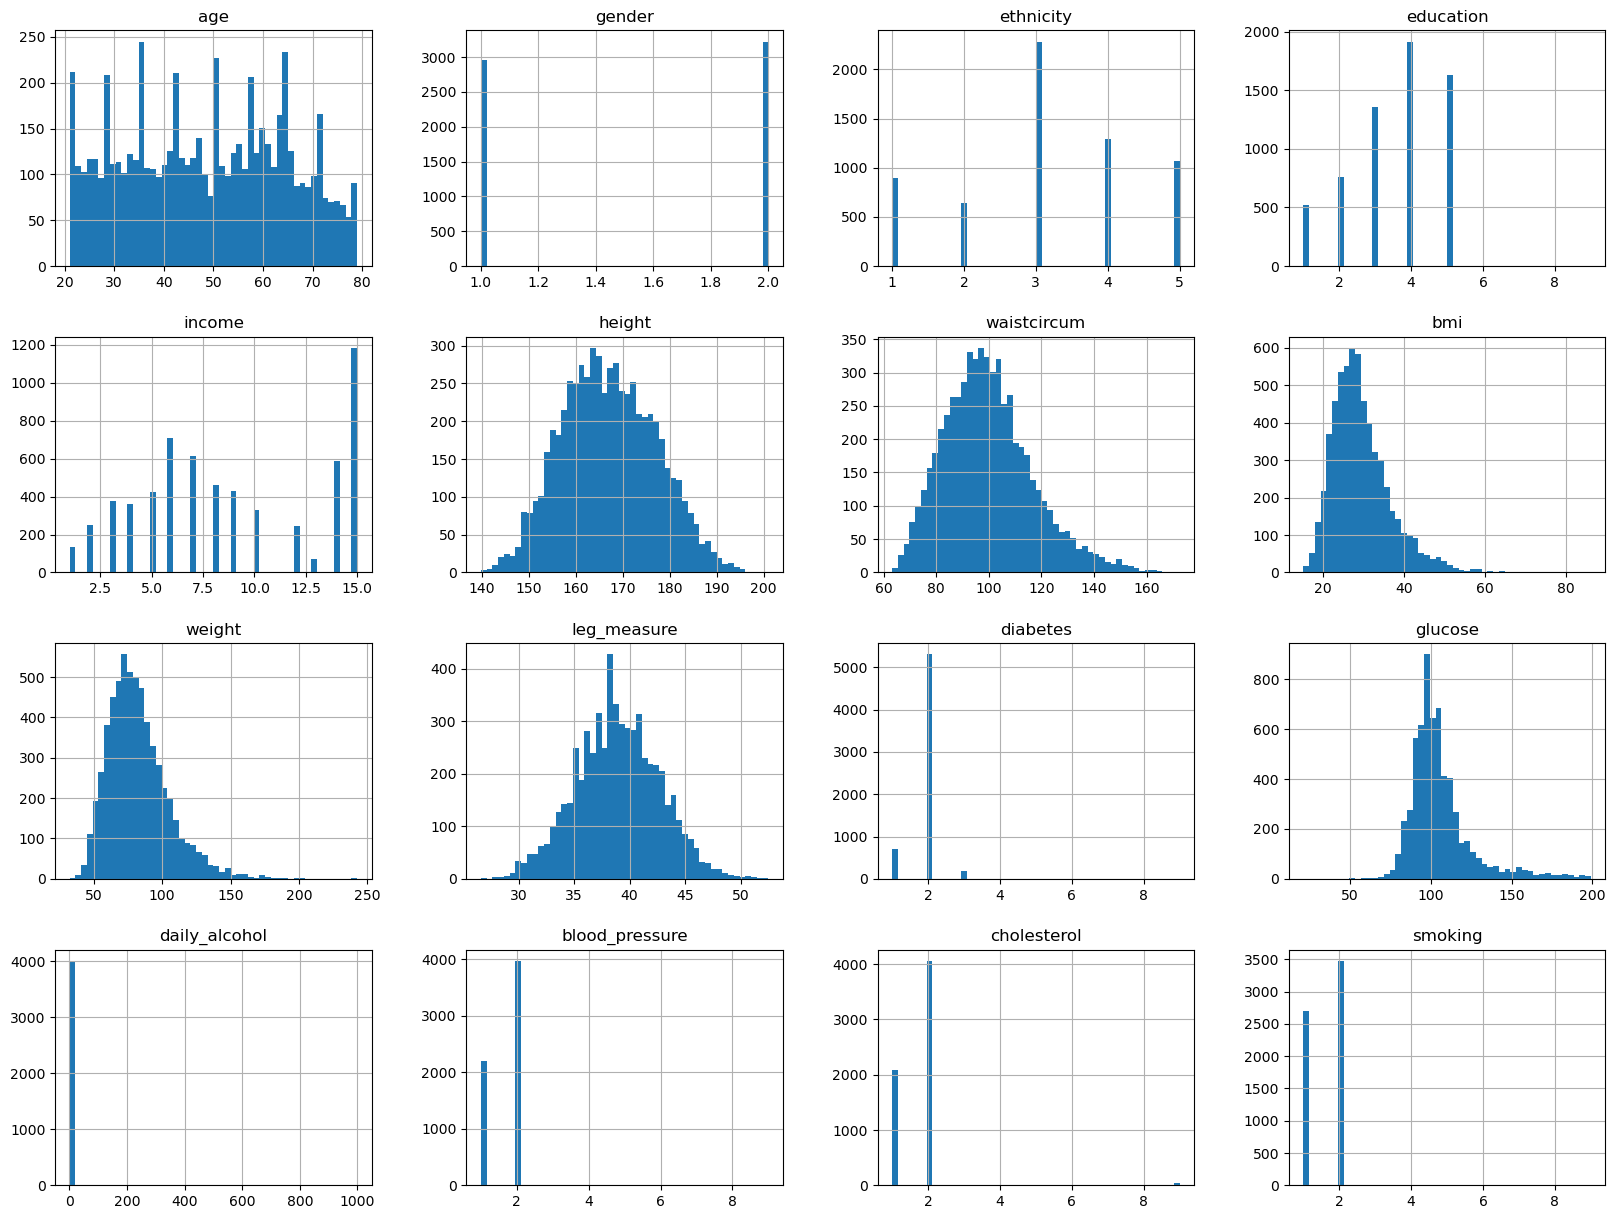

In [22]:
# Take a look at our distributions
graphs = db_df
# Restrict graphs so that we aren't viewing outliers
graphs = graphs[graphs['age'] < 80]
graphs = graphs[graphs['income'] < 60]
graphs = graphs[graphs['glucose'] < 200]
graphs.hist(bins=50, figsize=(20,15))
plt.show()

### Fill in missing values

In [23]:
# Null values in
# INDHHIN2 = Annual household income - we'll use fill-forward for this one
db_df['income'].fillna(method='ffill', inplace=True)
# ALL BMX values: - we'll use medians for these
#   - BMXHT = Standing Height (cm)
#   - BMXWAIST = Waist Circumference (cm)
#   - BMXBMI = Body Mass Index (kg/m**2)
#   - BMXWT = Weight (kg)
#   - BMXLEG = Upper Leg Length (cm)
db_df[['height', 'waistcircum', 'bmi', 'weight', 'leg_measure', 'daily_alcohol']] = db_df[['height', 'waistcircum', 'bmi', 
                                                                          'weight', 'leg_measure', 'daily_alcohol']].fillna(db_df[['height', 'waistcircum', 
                                                                                                                  'bmi', 'weight', 'leg_measure', 'daily_alcohol']].median())

# LBXGLU = fasting glucose level; 99 mg/dL = normal, 100–125 mg/dL = pre-diabetes, 126 mg/dL or above = diabetes
# We'll use mode for LBXGLU, because we don't want to assume that all those w/o LBXGLU values are immediately pre-diabetes or have diabetes

In [24]:
#look at the count and percentage of missing values again
missing = pd.concat([db_df.isnull().sum(), 100*db_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
age,0,0.0
gender,0,0.0
ethnicity,0,0.0
education,0,0.0
income,0,0.0
height,0,0.0
waistcircum,0,0.0
bmi,0,0.0
weight,0,0.0
leg_measure,0,0.0


In [25]:
db_df.shape

(7351, 16)

### Develop a pipeline for new attributes, recoding categorical data that is not ordinal, and normalizing numeric data

In [26]:
db_df.dtypes

age               float64
gender            float64
ethnicity         float64
education         float64
income            float64
height            float64
waistcircum       float64
bmi               float64
weight            float64
leg_measure       float64
diabetes          float64
glucose           float64
daily_alcohol     float64
blood_pressure    float64
cholesterol       float64
smoking           float64
dtype: object

In [27]:
dtype_cols = [col for col in db_df.columns if col not in ['glucose']]

for col in dtype_cols:
    db_df[col] = db_df[col].astype('int')
db_df.dtypes

age                 int32
gender              int32
ethnicity           int32
education           int32
income              int32
height              int32
waistcircum         int32
bmi                 int32
weight              int32
leg_measure         int32
diabetes            int32
glucose           float64
daily_alcohol       int32
blood_pressure      int32
cholesterol         int32
smoking             int32
dtype: object

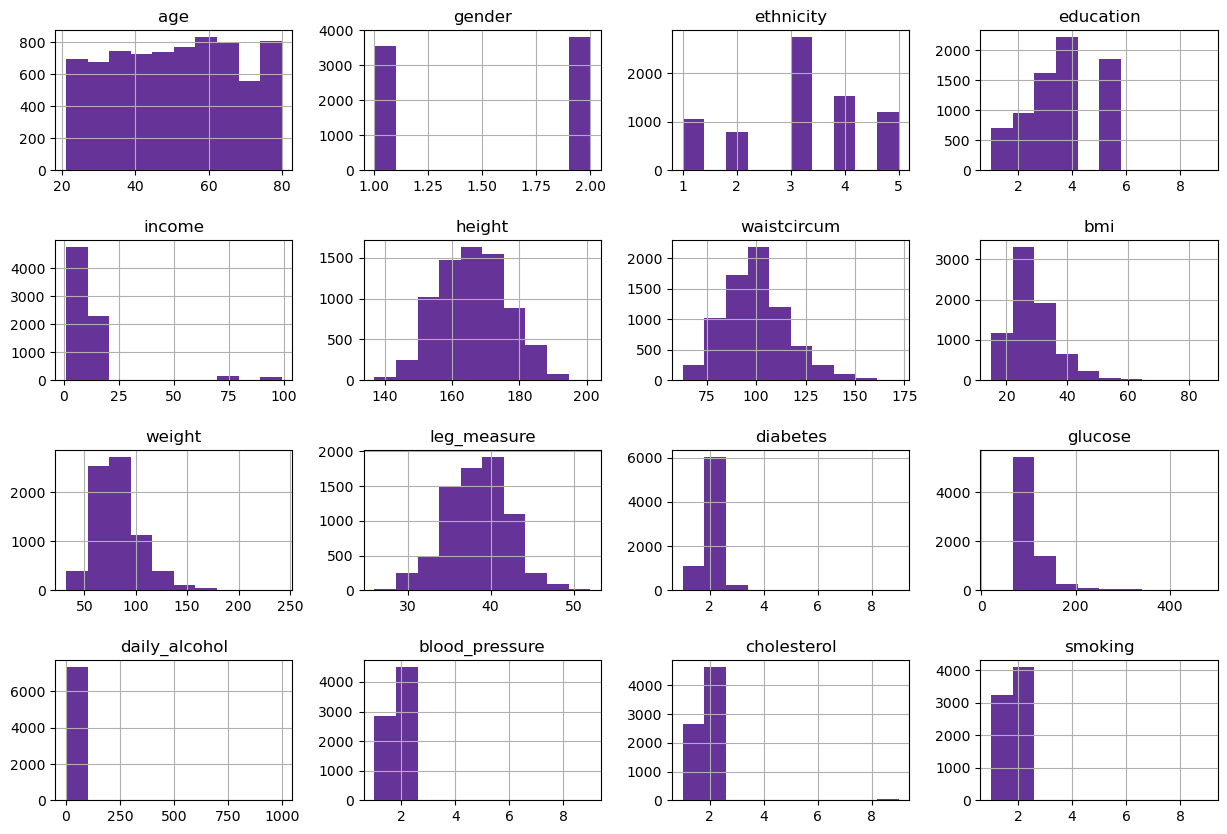

In [28]:
#let's get the histograms to get an idea of their distributions
db_df.hist(figsize=(15, 10), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [29]:
# Function to assist for adding attributes
def diab(fgl, diag):
    if ((fgl > 125) or (diag == 1)):
        return 1
    else:
        return 0

In [30]:
def db_recode_values(db_df):
    #replace the 1(male) from the original dataset to 0 and 2(female) to 1
    db_df['gender'].replace({1: 0, 2: 1}, inplace=True)

    #Here 1 to 5 indicates education level at or below college, 7 means refused, and 9 means don't know
    # Replace 7 and 9 by mode(some college or AA degree)
    db_df['education'].replace({7: 4, 9: 4}, inplace=True)

    # replace 13(under $20,000) by 4($15,000 to $19,999)
    #replace 12(over $20,000), 77(refused) and 99(don't know) by mode($25,000 to $34,999).
    db_df['income'].replace({13: 4, 12: 6, 77: 6, 99: 6}, inplace=True)

    #Here 1 means the individual has been told they have diabetes, 2 means no diabetes, 3 means borderline and 9 stands for refused
    #replace 3 by 1 and 9 by 2
    db_df['diabetes'].replace({3: 1, 9: 2}, inplace=True)

    #Here 777 means refused and 9 stands for unknown
    #replace 777 and 999 by mode (2)
    db_df['daily_alcohol'].replace({777: 2, 999: 2}, inplace=True)

    #Here 7 stands for refused and 9 stands for unknown
    #replace 7 and 9 by 2 (not diagnosed)
    db_df['blood_pressure'].replace({7: 2, 9: 2}, inplace=True)
    db_df['blood_pressure'].replace({1: 0, 2: 1}, inplace=True)

    #Here 7 stands for refused and 9 stands for unknown
    #replace 7 and 9 by 2 (not diagnosed)
    db_df['cholesterol'].replace({7: 2, 9: 2}, inplace=True)
    db_df['cholesterol'].replace({1: 0, 2: 1}, inplace=True)

    #Here 7 stands for refused and 9 stands for unknown
    #replace 7 and 9 by 2 (non-smoker)
    db_df['smoking'].replace({7: 2, 9: 2}, inplace=True)
    db_df['smoking'].replace({1: 0, 2: 1}, inplace=True)

    return db_df

In [31]:
# These will act as our labels
def db_add_attributes(db_df):
    if ('glucose' in db_df.columns) & ('diabetes' in db_df.columns) :
       db_df['diabetes_cat'] = db_df.apply(lambda x : diab(x['glucose'], x['diabetes']), axis=1)
    return db_df

In [32]:
# We don't want labels in our training data
def db_drop_columns(db_df):
        if ('glucose' in db_df.columns) & ('diabetes' in db_df.columns) :
            db_df = db_df.drop(columns=['glucose','diabetes'],axis=1)
        return db_df


In [33]:
def db_add_trim__recode_drop(db_df):
    db_df = db_recode_values(db_df)
    db_df = db_add_attributes(db_df)
    db_df = db_drop_columns(db_df)

    return db_df

In [34]:
db_df.head(10)

,age,gender,ethnicity,education,income,height,waistcircum,bmi,weight,leg_measure,diabetes,glucose,daily_alcohol,blood_pressure,cholesterol,smoking
0,72,1,3,4,10,175,109,28,88,40,1,193.0,2,1,1,1
1,73,2,3,5,15,162,98,19,52,36,2,107.0,2,1,2,2
2,61,2,3,5,10,161,110,35,93,37,2,110.0,1,1,2,2
3,26,2,3,5,15,152,73,20,47,34,2,89.0,2,2,2,2
4,33,2,5,5,8,158,78,22,56,37,2,84.0,2,2,2,2
5,32,1,1,1,5,166,100,28,79,36,2,104.0,15,2,2,1
6,38,2,4,3,12,161,107,35,93,40,2,103.0,3,2,2,2
7,50,1,5,5,15,185,99,23,80,42,2,110.0,2,2,1,2
8,57,2,5,5,15,164,117,38,104,35,2,107.0,2,1,2,1
9,37,1,4,3,5,185,122,36,126,48,2,127.0,5,1,2,1


In [35]:
db_df = db_add_trim__recode_drop(db_df)
db_df.head(10)

,age,gender,ethnicity,education,income,height,waistcircum,bmi,weight,leg_measure,daily_alcohol,blood_pressure,cholesterol,smoking,diabetes_cat
0,72,0,3,4,10,175,109,28,88,40,2,0,0,0,1
1,73,1,3,5,15,162,98,19,52,36,2,0,1,1,0
2,61,1,3,5,10,161,110,35,93,37,1,0,1,1,0
3,26,1,3,5,15,152,73,20,47,34,2,1,1,1,0
4,33,1,5,5,8,158,78,22,56,37,2,1,1,1,0
5,32,0,1,1,5,166,100,28,79,36,15,1,1,0,0
6,38,1,4,3,6,161,107,35,93,40,3,1,1,1,0
7,50,0,5,5,15,185,99,23,80,42,2,1,0,1,0
8,57,1,5,5,15,164,117,38,104,35,2,0,1,0,0
9,37,0,4,3,5,185,122,36,126,48,5,0,1,0,1


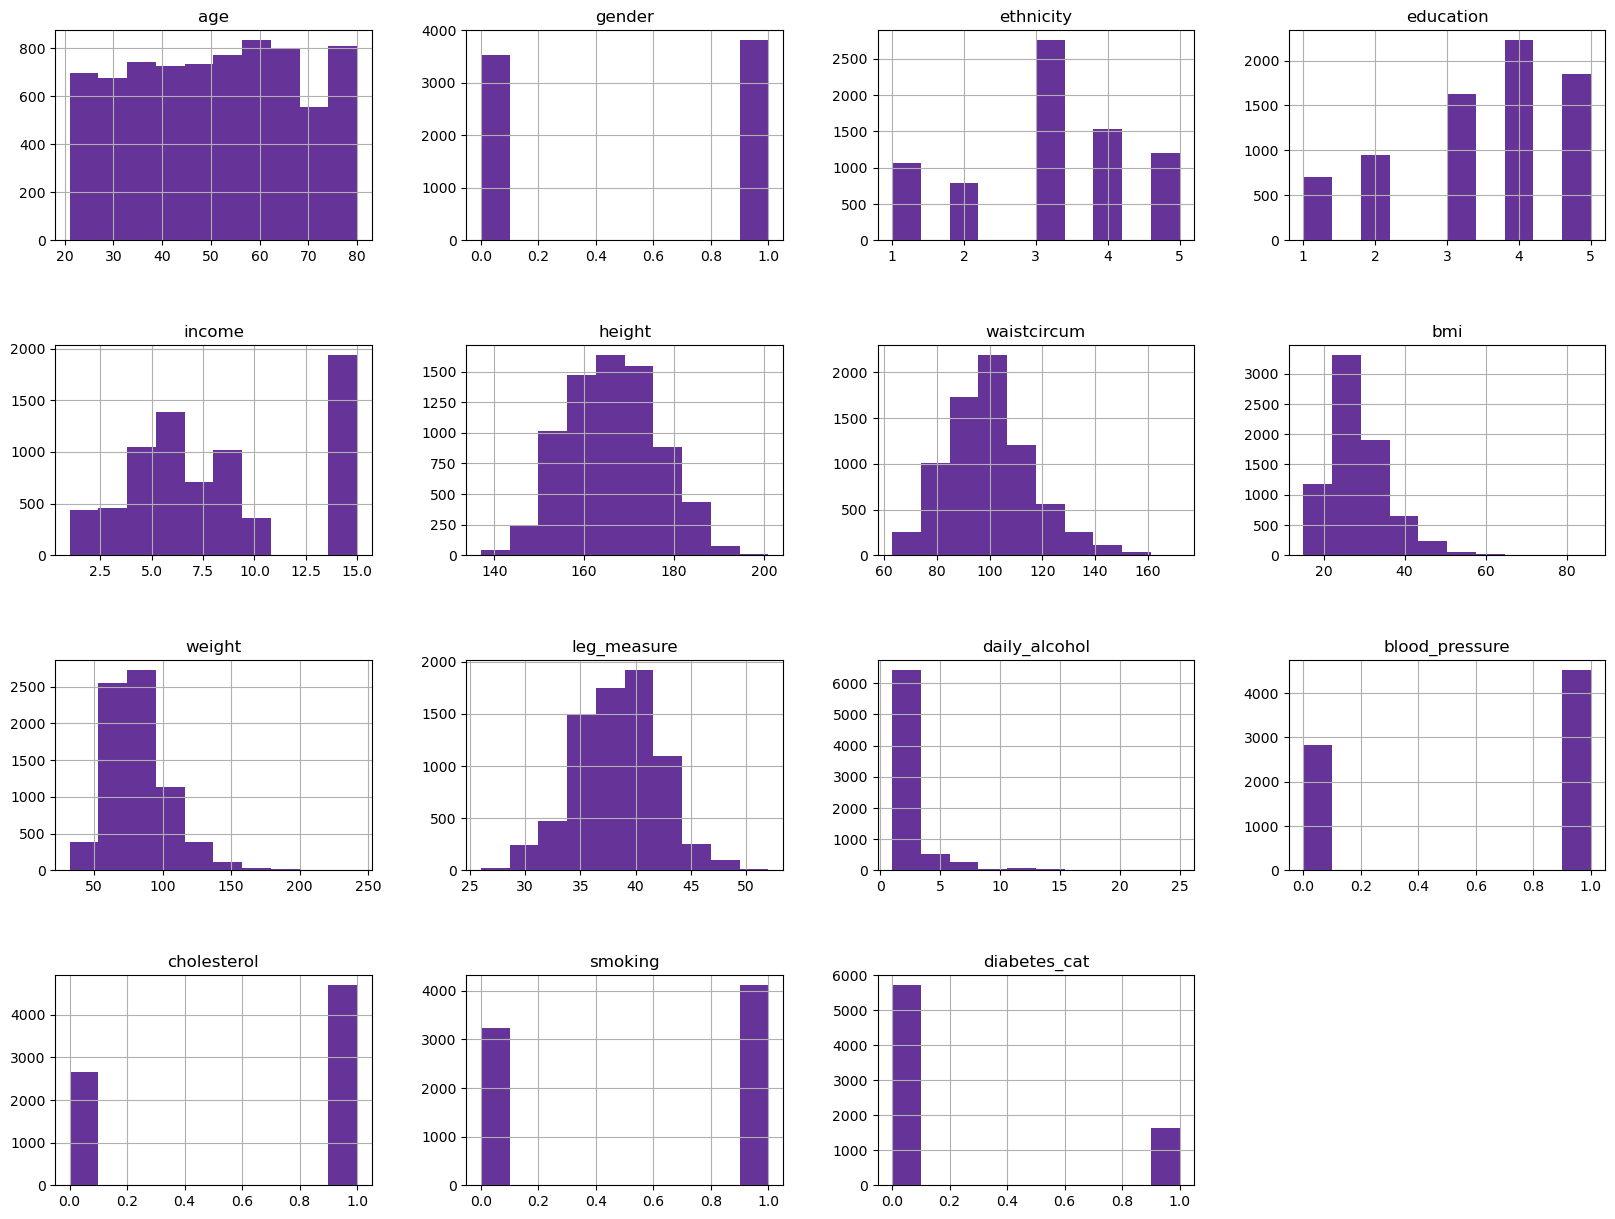

In [36]:
#get the new histograms to get an idea of their distributions
db_df.hist(figsize=(20, 15), color='rebeccapurple')
plt.subplots_adjust(hspace=0.5)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

### More exploratory analysis

In [38]:
y = db_df['diabetes_cat']
X = db_df.drop('diabetes_cat',axis=1)

In [39]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
X_train,  X_val, y_train, y_val = train_test_split(X_train,y_train,  test_size=0.1, random_state=19)

In [40]:
#confirming the ratios of train, test and validation sets for X
print('Percent heldout for training:', round(100*(len(X_train)/len(db_df)),0),'%')
print('Percent heldout for validation', round(100*(len(X_val)/len(db_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(X_test)/len(db_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation 8.0 %
Percent heldout for testing: 20.0 %


In [41]:
#confirming the ratios of train, test and validation sets for y
print('Percent heldout for training:', round(100*(len(y_train)/len(db_df)),0),'%')
print('Percent heldout for validation:', round(100*(len(y_val)/len(db_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(y_test)/len(db_df)),0),'%')

Percent heldout for training: 72.0 %
Percent heldout for validation: 8.0 %
Percent heldout for testing: 20.0 %


In [42]:
y_train.value_counts(normalize=True)

diabetes_cat
0    0.776644
1    0.223356
Name: proportion, dtype: float64

In [43]:
y_val.value_counts(normalize=True)

diabetes_cat
0    0.77381
1    0.22619
Name: proportion, dtype: float64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'diabetes_cat'),
  Text(0, 1.5, 'gender'),
  Text(0, 2.5, 'age'),
  Text(0, 3.5, 'bmi'),
  Text(0, 4.5, 'waistcircum'),
  Text(0, 5.5, 'height'),
  Text(0, 6.5, 'weight'),
  Text(0, 7.5, 'leg_measure'),
  Text(0, 8.5, 'income'),
  Text(0, 9.5, 'daily_alcohol'),
  Text(0, 10.5, 'blood_pressure'),
  Text(0, 11.5, 'cholesterol'),
  Text(0, 12.5, 'smoking')])

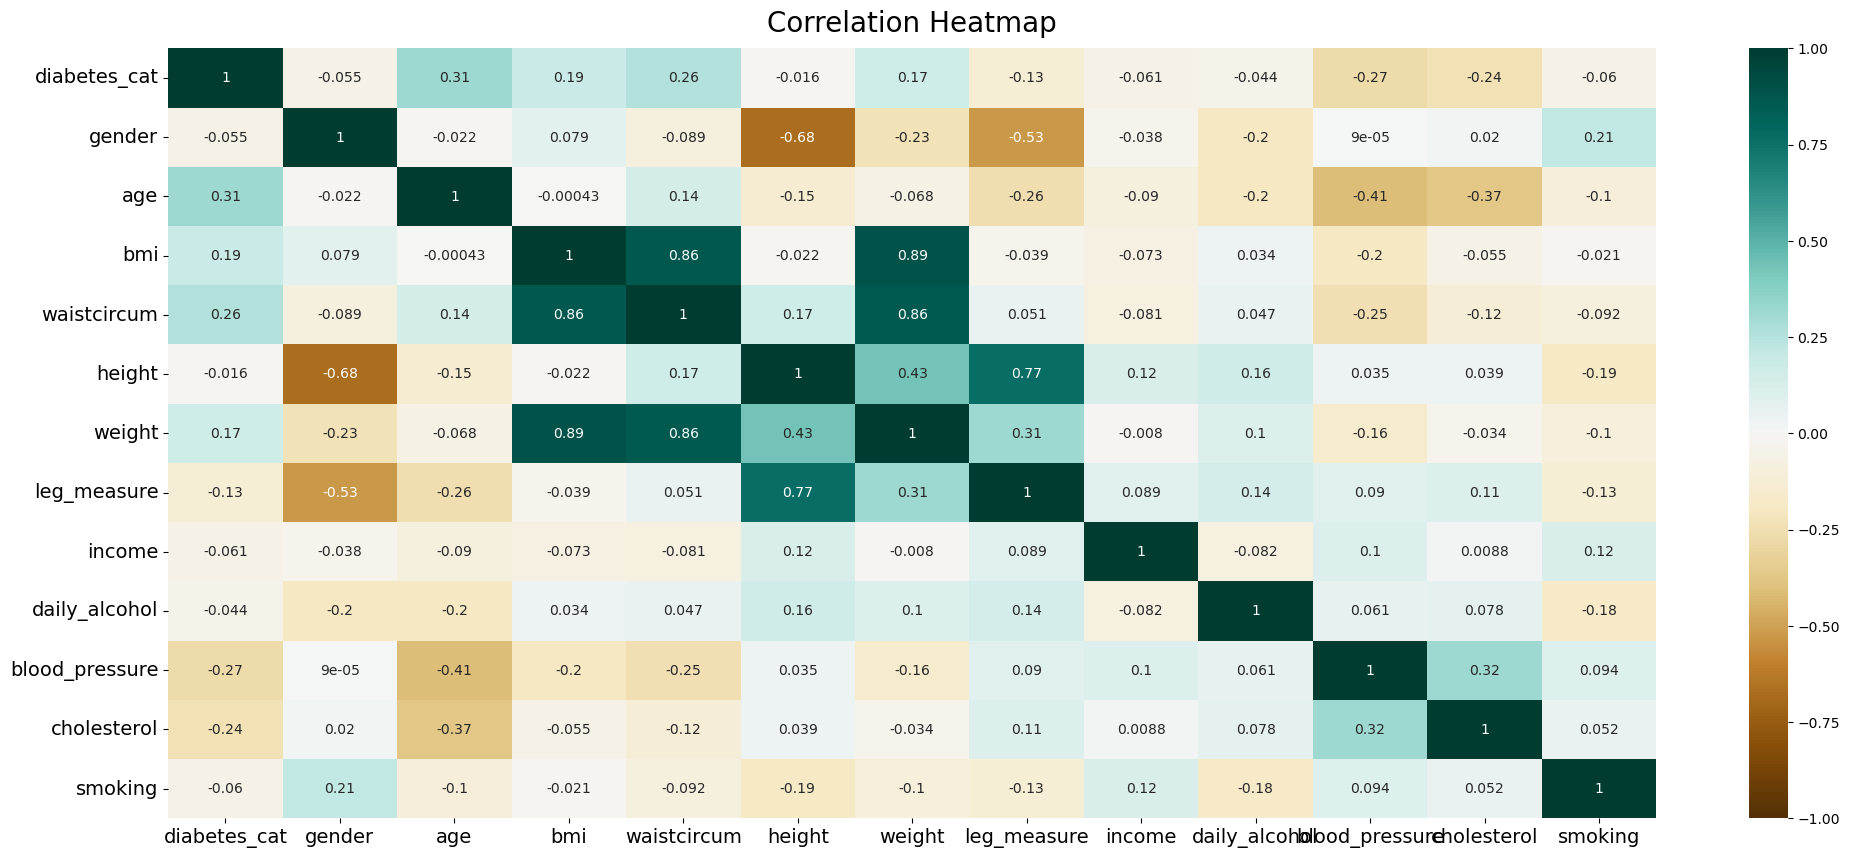

In [44]:
Xy_train = X_train.copy()
Xy_train['diabetes_cat'] = y_train

# Adding heatmaps
corr = Xy_train[['diabetes_cat', 'gender', 'age',  'bmi', 'waistcircum', 'height', 'weight', 'leg_measure', 'income', 'daily_alcohol', 'blood_pressure', 'cholesterol', 'smoking']].corr()
plt.figure(figsize=(24,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')

In [45]:
X_train.head()

,age,gender,ethnicity,education,income,height,waistcircum,bmi,weight,leg_measure,daily_alcohol,blood_pressure,cholesterol,smoking
6795,67,0,3,2,9,169,114,33,95,38,3,0,1,0
4594,26,1,3,5,6,183,95,27,92,42,2,1,1,1
6606,79,0,3,5,4,163,105,27,73,40,2,0,1,0
2177,23,0,3,3,9,173,87,23,70,40,2,1,1,1
523,79,0,1,1,5,169,117,30,87,39,2,1,1,0


# 3.0 Pipeline and Models

## 3.1 Create a pipeline for categorical and numerical attributes

In [46]:
X_train.columns

Index(['age', 'gender', 'ethnicity', 'education', 'income', 'height',
       'waistcircum', 'bmi', 'weight', 'leg_measure', 'daily_alcohol',
       'blood_pressure', 'cholesterol', 'smoking'],
      dtype='object')

In [47]:
num_attribs = ['age', 'income', 'height', 'waistcircum', 'bmi', 'weight', 'leg_measure', 'daily_alcohol']
cat_attribs = ["gender","ethnicity", "education", "blood_pressure", "cholesterol", "smoking"]

In [48]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])

In [49]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
db_prepared = full_pipeline.fit_transform(X_train)

In [50]:
db_prepared.shape

(5292, 26)

In [51]:
db_prepared[1,0:19]

array([-1.45727309, -0.52778095,  1.67547323, -0.28986502, -0.28218656,
        0.47430066,  0.9898514 , -0.21128636,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [52]:
db_df[cat_attribs].apply(pd.Series.value_counts)

,gender,ethnicity,education,blood_pressure,cholesterol,smoking
0,3539.0,NaN,NaN,2835.0,2656.0,3239.0
1,3812.0,1063.0,701.0,4516.0,4695.0,4112.0
2,NaN,788.0,946.0,NaN,NaN,NaN
3,NaN,2755.0,1625.0,NaN,NaN,NaN
4,NaN,1538.0,2225.0,NaN,NaN,NaN
5,NaN,1207.0,1854.0,NaN,NaN,NaN


## 3.2 Train various models

## Use the Stochastic Gradient Descent Classifier on the training data

In [54]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=19)
sgd_clf.fit(db_prepared, y_train)

SGDClassifier(random_state=19)

In [55]:
some_data = db_prepared[5]
some_labels = y_train.iloc[5]
sgd_clf.predict([some_data])

array([0], dtype=int64)

### Evaluation

In [56]:
cross_val_score(sgd_clf, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.78628118, 0.76417234, 0.79648526])

In [57]:
y_train_pred = cross_val_predict(sgd_clf, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[3766,  344],
       [ 808,  374]], dtype=int64)

In [58]:
# Confirm binary classifier
sgd_clf.classes_

array([0, 1], dtype=int64)

### Precision and Recall

In [59]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.520891364902507
0.3164128595600677
0.3936842105263158


## Use the Ridge Classifier on the training data

In [181]:
# Use GridSearch to find best hyperparameters for SGD
from sklearn.linear_model import RidgeClassifier

param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter' : [100, 500, 1000],
    'tol' : [0.0001, 0.00001, 0.000001],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
}

In [182]:
ridge_reg = RidgeClassifier()

In [183]:
grid_search = GridSearchCV(
    ridge_reg, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
    )

grid_search.fit(db_prepared, y_train)

c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sj\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 1.0, 10.0],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 500, 1000],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs'],
                         'tol': [0.0001, 1e-05, 1e-06]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [184]:
grid_search.best_params_

{'alpha': 10.0,
 'fit_intercept': False,
 'max_iter': 100,
 'solver': 'auto',
 'tol': 0.0001}

In [188]:
ridge_reg = RidgeClassifier(
    alpha=10.0,
    fit_intercept=False,
    max_iter=100,
    solver='auto',
    tol=0.0001,
    random_state=19)

ridge_reg.fit(db_prepared, y_train)
ridge_reg.predict([some_data])

array([0], dtype=int64)

### Evaluation

In [189]:
cross_val_score(ridge_reg, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.7845805 , 0.78911565, 0.80272109])

In [190]:
y_train_pred = cross_val_predict(ridge_reg, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[3992,  118],
       [ 982,  200]], dtype=int64)

In [63]:
# Confirm binary classifier
ridge_reg.classes_

array([0, 1], dtype=int64)

### Precision and Recall

In [191]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.6289308176100629
0.1692047377326565
0.26666666666666666


## Use the Support Vector Machine (SVM) Classifier on the training data

In [72]:
from sklearn.svm import SVC
svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(
    kernel="poly", 
    degree=3, 
    coef0=1, 
    C=10, 
    random_state=19))
])
svm_clf.fit(db_prepared, y_train)
svm_clf.predict([some_data])

array([0], dtype=int64)

### Evaluation

In [73]:
cross_val_score(svm_clf, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.76870748, 0.74943311, 0.77154195])

In [74]:
y_train_pred = cross_val_predict(svm_clf, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[3614,  496],
       [ 757,  425]], dtype=int64)

In [76]:
# Confirm binary classifier
svm_clf.classes_

array([0, 1], dtype=int64)

### Precision and Recall

In [77]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.46145494028230183
0.3595600676818951
0.4041844983357109


## Use the Decision Tree Classifier on the training data

In [192]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'class_weight': [None, 'balanced']
}

In [193]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

In [194]:
grid_search = GridSearchCV(
    tree_clf, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
    )

grid_search.fit(db_prepared, y_train)

c:\Users\sj\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12960 fits failed out of a total of 51840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12960 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sj\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sj\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\sj\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\sj\anaconda3\Lib\site-packages\sklear

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 20, 30],
                         'min_impurity_decrease': [0.0, 0.1, 0.2],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [195]:
grid_search.best_params_

{'class_weight': None,
 'criterion': 'log_loss',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [196]:
tree_clf = DecisionTreeClassifier(
    class_weight=None,
    criterion='log_loss',
    max_depth=5,
    max_features='sqrt',
    max_leaf_nodes=10,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=19
    )
tree_clf.fit(db_prepared, y_train)
tree_clf.predict([some_data])

array([0], dtype=int64)

### Evaluation

In [197]:
cross_val_score(tree_clf, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.7755102 , 0.76360544, 0.79195011])

In [198]:
y_train_pred = cross_val_predict(tree_clf, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[3891,  219],
       [ 961,  221]], dtype=int64)

In [164]:
# Confirm binary classifier
tree_clf.classes_

array([0, 1], dtype=int64)

### Precision and Recall

In [199]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.5022727272727273
0.18697123519458544
0.2725030826140567


## Use the Random Forest Classifier on the training data

In [206]:
param_grid = [
    {'n_estimators': [10, 100, 500], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features': [None, 2, 3, 4]},
]

In [207]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()

In [208]:
grid_search = GridSearchCV(
    rnd_clf, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
    )

grid_search.fit(db_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 100, 500]},
                         {'bootstrap': [False], 'max_features': [None, 2, 3, 4],
                          'n_estimators': [100, 500]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [209]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 500}

In [210]:
rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1, 
    max_depth=10, 
    min_samples_leaf=4, 
    min_samples_split=8, 
    max_features=8, 
    random_state=19
    )
rnd_clf.fit(db_prepared, y_train)
rnd_clf.predict([some_data])

array([0], dtype=int64)

### Evaluation

In [211]:
cross_val_score(rnd_clf, db_prepared, y_train, cv=3, scoring="accuracy")

array([0.78911565, 0.78514739, 0.79251701])

In [212]:
y_train_pred = cross_val_predict(rnd_clf, db_prepared, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[3973,  137],
       [ 980,  202]], dtype=int64)

In [143]:
# Confirm binary classifier
rnd_clf.classes_

array([0, 1], dtype=int64)

### Precision and Recall

In [213]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.5958702064896755
0.17089678510998307
0.2656147271531887


## 3.3 Compare model results

In [214]:
y_scores_sgd = cross_val_predict(sgd_clf, db_prepared, y_train, cv=3, method="decision_function")
y_scores_ridge = cross_val_predict(ridge_reg, db_prepared, y_train, cv=3, method="decision_function")
y_scores_svm = cross_val_predict(svm_clf, db_prepared, y_train, cv=3, method="decision_function")
y_scores_dt = cross_val_predict(tree_clf, db_prepared, y_train, cv=3, method="predict_proba")
y_scores_rf = cross_val_predict(rnd_clf, db_prepared, y_train, cv=3, method="predict_proba")

# Picking probability column
diab_prob_dt = y_scores_dt[:, 1]
diab_prob_rf = y_scores_rf[:, 1]

precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd)
precisions_ridge, recalls_ridge, thresholds_ridge = precision_recall_curve(y_train, y_scores_ridge)
precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(y_train, y_scores_svm)
precisions_dt, recalls_dt, thresholds_dt = precision_recall_curve(y_train, diab_prob_dt)
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train, diab_prob_rf)


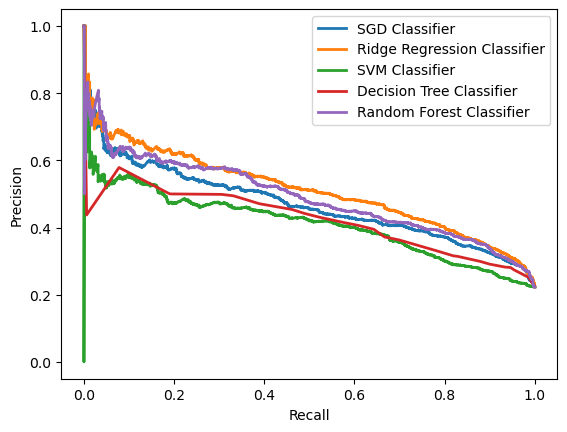

In [215]:
def plot_precision_vs_recall(precisions, recalls, label=None):
  plt.plot(recalls, precisions, linewidth=2, label=label)
  # Label the x-axis and y-axis

plot_precision_vs_recall(precisions_sgd, recalls_sgd, label='SGD Classifier')
plot_precision_vs_recall(precisions_ridge, recalls_ridge, label='Ridge Classifier')
plot_precision_vs_recall(precisions_svm, recalls_svm, label='SVM Classifier')
plot_precision_vs_recall(precisions_dt, recalls_dt, label='Decision Tree Classifier')
plot_precision_vs_recall(precisions_rf, recalls_rf, label='Random Forest Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

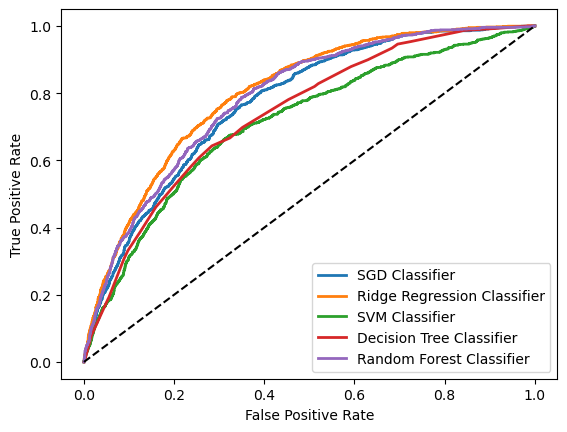

In [216]:
# ROC curve for SGD Classifier
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

# ROC curve for Ridge Classifier
fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(y_train, y_scores_ridge)

# ROC curve for SVM Classifier
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

# ROC curve for Decision Tree Classifier
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_train, diab_prob_dt)

# ROC curve for Random Forest Classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, diab_prob_rf)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# Plot all three ROC curves on the same graph
plot_roc_curve(fpr_sgd, tpr_sgd, label='SGD Classifier')
plot_roc_curve(fpr_ridge, tpr_ridge, label='Ridge Classifier')
plot_roc_curve(fpr_svm, tpr_svm, label='SVM Classifier')
plot_roc_curve(fpr_dt, tpr_dt, label='Decision Tree Classifier')
plot_roc_curve(fpr_rf, tpr_rf, label='Random Forest Classifier')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Label the x-axis and y-axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add a legend to the plot
plt.legend()

# Show the ROC curve plot
plt.show()


## 3.4 Evaluate on test set

In [227]:
# Switch to test set

y_scores_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=3, method="decision_function")
y_scores_ridge = cross_val_predict(ridge_reg, X_test, y_test, cv=3, method="decision_function")
y_scores_svm = cross_val_predict(svm_clf, X_test, y_test, cv=3, method="decision_function")
y_scores_dt = cross_val_predict(tree_clf, X_test, y_test, cv=3, method="predict_proba")
y_scores_rf = cross_val_predict(rnd_clf, X_test, y_test, cv=3, method="predict_proba")

# Picking probability column
diab_prob_dt = y_scores_dt[:, 1]
diab_prob_rf = y_scores_rf[:, 1]

precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_test, y_scores_sgd)
precisions_ridge, recalls_ridge, thresholds_ridge = precision_recall_curve(y_test, y_scores_ridge)
precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(y_test, y_scores_svm)
precisions_dt, recalls_dt, thresholds_dt = precision_recall_curve(y_test, diab_prob_dt)
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, diab_prob_rf)


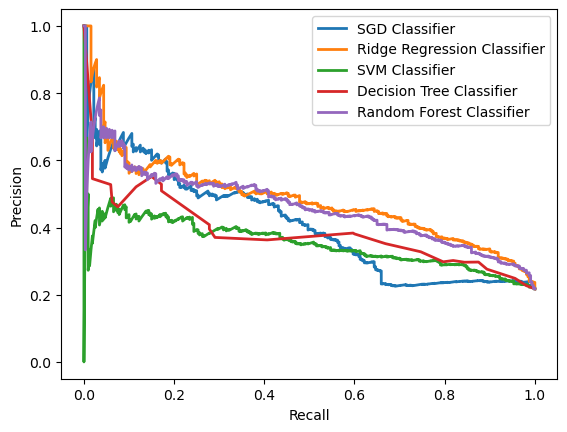

In [228]:
def plot_precision_vs_recall(precisions, recalls, label=None):
  plt.plot(recalls, precisions, linewidth=2, label=label)
  # Label the x-axis and y-axis

plot_precision_vs_recall(precisions_sgd, recalls_sgd, label='SGD Classifier')
plot_precision_vs_recall(precisions_ridge, recalls_ridge, label='Ridge Classifier')
plot_precision_vs_recall(precisions_svm, recalls_svm, label='SVM Classifier')
plot_precision_vs_recall(precisions_dt, recalls_dt, label='Decision Tree Classifier')
plot_precision_vs_recall(precisions_rf, recalls_rf, label='Random Forest Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

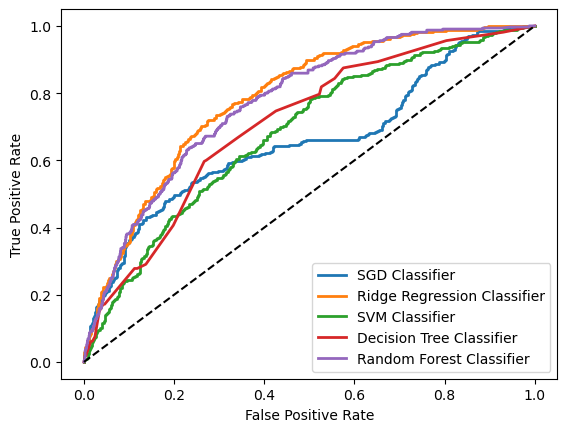

In [229]:
# ROC curve for SGD Classifier
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test, y_scores_sgd)

# ROC curve for Ridge Classifier
fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(y_test, y_scores_ridge)

# ROC curve for SVM Classifier
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_scores_svm)

# ROC curve for Decision Tree Classifier
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, diab_prob_dt)

# ROC curve for Random Forest Classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, diab_prob_rf)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# Plot all three ROC curves on the same graph
plot_roc_curve(fpr_sgd, tpr_sgd, label='SGD Classifier')
plot_roc_curve(fpr_ridge, tpr_ridge, label='Ridge Classifier')
plot_roc_curve(fpr_svm, tpr_svm, label='SVM Classifier')
plot_roc_curve(fpr_dt, tpr_dt, label='Decision Tree Classifier')
plot_roc_curve(fpr_rf, tpr_rf, label='Random Forest Classifier')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Label the x-axis and y-axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add a legend to the plot
plt.legend()

# Show the ROC curve plot
plt.show()


## Evaluation for two best models

In [239]:
# Ridge Classifier
cross_val_score(ridge_reg, X_test, y_test, cv=3, scoring="accuracy")

array([0.81466395, 0.79591837, 0.77346939])

In [240]:
y_test_pred = cross_val_predict(ridge_reg, X_test, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)

array([[1107,   44],
       [ 258,   62]], dtype=int64)

In [241]:
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))

0.5849056603773585
0.19375
0.29107981220657275


In [242]:
# Random Forest
cross_val_score(rnd_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.79837067, 0.77755102, 0.79183673])

In [243]:
y_test_pred = cross_val_predict(rnd_clf, X_test, y_test, cv=3)
confusion_matrix(y_test, y_test_pred)

array([[1105,   46],
       [ 264,   56]], dtype=int64)

In [244]:
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))

0.5490196078431373
0.175
0.2654028436018957


In [ ]:
# include references to notebooks you used
# Lab 4
# Lab 5
# Lab 6
# Lab 7